<h1><center>Sales Analysis<center><h1>

<h1><center>Import the required libraries and foundational code</center></h1>

In [2]:
# Load libraries for analysis.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from utilsforecast.plotting import plot_series
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import *
from statsforecast import StatsForecast


import warnings


/opt/anaconda3/envs/arima/lib/python3.12/site-packages/fs/__init__.py:4: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  __import__("pkg_resources").declare_namespace(__name__)  # type: ignore
/opt/anaconda3/envs/arima/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# This code standardizes illustrations
plt.rcParams['figure.figsize'] = [10,8]
plt.rc('axes', titlesize= 20, labelsize =15)
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.family'] = 'serif' # Example: change font family

In [4]:
# ignores supplemental warnings
warnings.filterwarnings('ignore')

<h1><center>Load data and perform feature engineerig</center></h1>

In [5]:
# Load data and display dataframe.
sales = pd.read_csv('sales_data.csv', 
                    index_col='Sale_Date', 
                    parse_dates=True,
                    dayfirst=True)

sales

,Product_ID,Sales_Rep,Region,Sales_Amount,Quantity_Sold,Product_Category,Unit_Cost,Unit_Price,Customer_Type,Discount,Payment_Method,Sales_Channel,Region_and_Sales_Rep
Sale_Date,,,,,,,,,,,,,
2023-02-03,1052,Bob,North,5053.97,18,Furniture,152.75,267.22,Returning,0.09,Cash,Online,North-Bob
2023-04-21,1093,Bob,West,4384.02,17,Furniture,3816.39,4209.44,Returning,0.11,Cash,Retail,West-Bob
2023-09-21,1015,David,South,4631.23,30,Food,261.56,371.40,Returning,0.20,Bank Transfer,Retail,South-David
2023-08-24,1072,Bob,South,2167.94,39,Clothing,4330.03,4467.75,New,0.02,Credit Card,Retail,South-Bob
2023-03-24,1061,Charlie,East,3750.20,13,Electronics,637.37,692.71,New,0.08,Credit Card,Online,East-Charlie
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-15,1010,Charlie,North,4733.88,4,Food,4943.03,5442.15,Returning,0.29,Cash,Online,North-Charlie
2023-09-07,1067,Bob,North,4716.36,37,Clothing,1754.32,1856.40,New,0.21,Bank Transfer,Retail,North-Bob
2023-04-27,1018,David,South,7629.70,17,Clothing,355.72,438.27,Returning,0.06,Bank Transfer,Online,South-David


In [6]:
# Display shape of the data frame.
print("The dimension of the data frame is:", sales.shape)

The dimension of the data frame is: (1000, 13)


In [7]:
# Display data types.
print("The data types in the data frame are:\n", sales.dtypes)

The data types in the data frame are:
 Product_ID                int64
Sales_Rep                object
Region                   object
Sales_Amount            float64
Quantity_Sold             int64
Product_Category         object
Unit_Cost               float64
Unit_Price              float64
Customer_Type            object
Discount                float64
Payment_Method           object
Sales_Channel            object
Region_and_Sales_Rep     object
dtype: object


In [8]:
# Create a new data frame called sales_t.
sales_t = sales
sales_t.head()

,Product_ID,Sales_Rep,Region,Sales_Amount,Quantity_Sold,Product_Category,Unit_Cost,Unit_Price,Customer_Type,Discount,Payment_Method,Sales_Channel,Region_and_Sales_Rep
Sale_Date,,,,,,,,,,,,,
2023-02-03,1052,Bob,North,5053.97,18,Furniture,152.75,267.22,Returning,0.09,Cash,Online,North-Bob
2023-04-21,1093,Bob,West,4384.02,17,Furniture,3816.39,4209.44,Returning,0.11,Cash,Retail,West-Bob
2023-09-21,1015,David,South,4631.23,30,Food,261.56,371.40,Returning,0.20,Bank Transfer,Retail,South-David
2023-08-24,1072,Bob,South,2167.94,39,Clothing,4330.03,4467.75,New,0.02,Credit Card,Retail,South-Bob
2023-03-24,1061,Charlie,East,3750.20,13,Electronics,637.37,692.71,New,0.08,Credit Card,Online,East-Charlie


In [9]:
# Drop redundant column
sales_t.drop(columns='Region_and_Sales_Rep', inplace=True)

In [10]:
# Create a new column to display the net price of the products
sales_t['Net_Price'] = sales_t['Unit_Price']-sales_t['Discount']

In [11]:
# Found a discrepency in Sales Amount column and recalculated based 
# on net price and quantity sold.
sales_t['Profit'] = sales_t['Net_Price'] * sales_t['Quantity_Sold']

In [12]:
# Created a total cost column.
sales_t['Total_Cost']= sales_t['Unit_Cost'] * sales_t['Quantity_Sold']

In [13]:
# Drop sales amount column 
sales_t = sales_t.drop(columns='Sales_Amount')

In [14]:
# Sort index 
sales_t = sales_t.sort_index()

In [15]:
sales_t.dtypes

Product_ID            int64
Sales_Rep            object
Region               object
Quantity_Sold         int64
Product_Category     object
Unit_Cost           float64
Unit_Price          float64
Customer_Type        object
Discount            float64
Payment_Method       object
Sales_Channel        object
Net_Price           float64
Profit              float64
Total_Cost          float64
dtype: object

In [16]:
# Display dataframe with new features.
sales_t.head()

,Product_ID,Sales_Rep,Region,Quantity_Sold,Product_Category,Unit_Cost,Unit_Price,Customer_Type,Discount,Payment_Method,Sales_Channel,Net_Price,Profit,Total_Cost
Sale_Date,,,,,,,,,,,,,,
2023-01-01,1070,Eve,South,12,Furniture,664.33,863.03,Returning,0.25,Bank Transfer,Retail,862.78,10353.36,7971.96
2023-01-01,1089,Charlie,North,35,Clothing,4071.01,4304.70,New,0.14,Credit Card,Online,4304.56,150659.60,142485.35
2023-01-01,1008,Eve,North,38,Clothing,4635.23,5075.44,Returning,0.05,Cash,Online,5075.39,192864.82,176138.74
2023-01-02,1064,David,South,10,Electronics,2242.01,2282.23,Returning,0.20,Credit Card,Online,2282.03,22820.30,22420.10
2023-01-02,1075,David,West,26,Electronics,4535.38,4557.56,New,0.00,Credit Card,Online,4557.56,118496.56,117919.88


In [17]:
sales_t.tail()

,Product_ID,Sales_Rep,Region,Quantity_Sold,Product_Category,Unit_Cost,Unit_Price,Customer_Type,Discount,Payment_Method,Sales_Channel,Net_Price,Profit,Total_Cost
Sale_Date,,,,,,,,,,,,,,
2023-12-31,1090,Eve,West,46,Clothing,4665.12,4675.90,New,0.19,Cash,Retail,4675.71,215082.66,214595.52
2023-12-31,1094,Bob,South,15,Food,4111.93,4338.67,Returning,0.26,Credit Card,Online,4338.41,65076.15,61678.95
2024-01-01,1018,Alice,West,24,Electronics,1362.78,1729.81,New,0.29,Bank Transfer,Online,1729.52,41508.48,32706.72
2024-01-01,1098,Bob,South,11,Clothing,213.41,503.36,Returning,0.27,Bank Transfer,Online,503.09,5533.99,2347.51
2024-01-01,1078,David,East,42,Food,63.41,314.93,Returning,0.03,Cash,Retail,314.90,13225.80,2663.22


In [18]:
sales_t.dtypes

Product_ID            int64
Sales_Rep            object
Region               object
Quantity_Sold         int64
Product_Category     object
Unit_Cost           float64
Unit_Price          float64
Customer_Type        object
Discount            float64
Payment_Method       object
Sales_Channel        object
Net_Price           float64
Profit              float64
Total_Cost          float64
dtype: object

In [19]:
salesOne_hot_encoding = pd.get_dummies(sales_t).replace({True:1, False:0})

In [20]:
salesOne_hot_encoding.head()

,Product_ID,Quantity_Sold,Unit_Cost,Unit_Price,Discount,Net_Price,Profit,Total_Cost,Sales_Rep_Alice,Sales_Rep_Bob,...,Product_Category_Electronics,Product_Category_Food,Product_Category_Furniture,Customer_Type_New,Customer_Type_Returning,Payment_Method_Bank Transfer,Payment_Method_Cash,Payment_Method_Credit Card,Sales_Channel_Online,Sales_Channel_Retail
Sale_Date,,,,,,,,,,,,,,,,,,,,,
2023-01-01,1070,12,664.33,863.03,0.25,862.78,10353.36,7971.96,0,0,...,0,0,1,0,1,1,0,0,0,1
2023-01-01,1089,35,4071.01,4304.70,0.14,4304.56,150659.60,142485.35,0,0,...,0,0,0,1,0,0,0,1,1,0
2023-01-01,1008,38,4635.23,5075.44,0.05,5075.39,192864.82,176138.74,0,0,...,0,0,0,0,1,0,1,0,1,0
2023-01-02,1064,10,2242.01,2282.23,0.20,2282.03,22820.30,22420.10,0,0,...,1,0,0,0,1,0,0,1,1,0
2023-01-02,1075,26,4535.38,4557.56,0.00,4557.56,118496.56,117919.88,0,0,...,1,0,0,1,0,0,0,1,1,0


In [21]:
sales_t.head()

,Product_ID,Sales_Rep,Region,Quantity_Sold,Product_Category,Unit_Cost,Unit_Price,Customer_Type,Discount,Payment_Method,Sales_Channel,Net_Price,Profit,Total_Cost
Sale_Date,,,,,,,,,,,,,,
2023-01-01,1070,Eve,South,12,Furniture,664.33,863.03,Returning,0.25,Bank Transfer,Retail,862.78,10353.36,7971.96
2023-01-01,1089,Charlie,North,35,Clothing,4071.01,4304.70,New,0.14,Credit Card,Online,4304.56,150659.60,142485.35
2023-01-01,1008,Eve,North,38,Clothing,4635.23,5075.44,Returning,0.05,Cash,Online,5075.39,192864.82,176138.74
2023-01-02,1064,David,South,10,Electronics,2242.01,2282.23,Returning,0.20,Credit Card,Online,2282.03,22820.30,22420.10
2023-01-02,1075,David,West,26,Electronics,4535.38,4557.56,New,0.00,Credit Card,Online,4557.56,118496.56,117919.88


<h1><center> Visualize data to find seasonality and trends </center></h1>

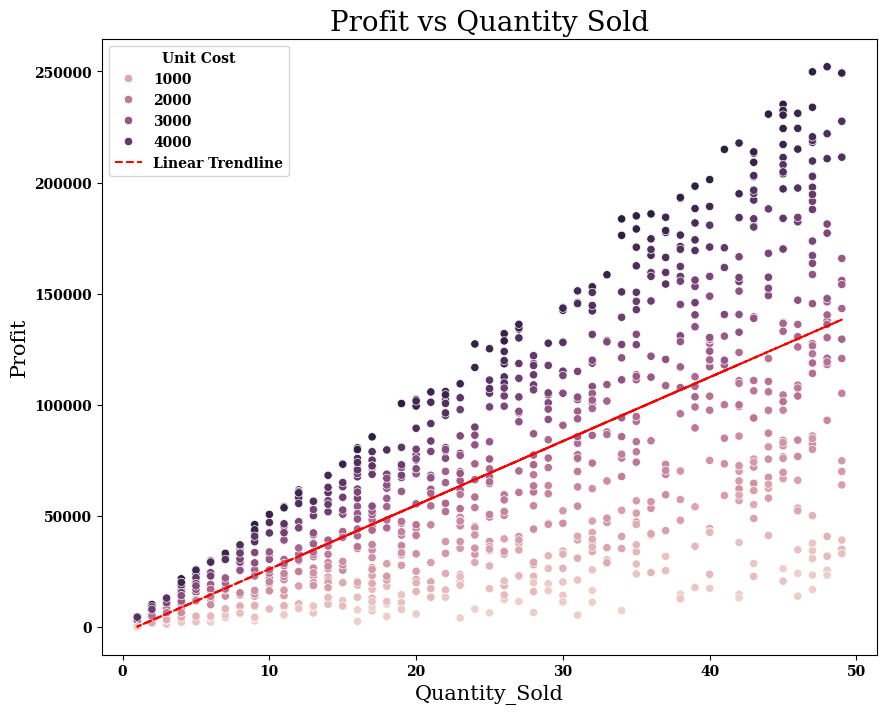

In [85]:
# scatter plot showing a positive trend with profit and quantity sold.
sns.scatterplot(data=salesOne_hot_encoding, x='Quantity_Sold', y='Profit', hue='Unit_Cost')
z = np.polyfit(salesOne_hot_encoding['Quantity_Sold'], salesOne_hot_encoding['Profit'], 1)
p = np.poly1d(z)
plt.plot(salesOne_hot_encoding['Quantity_Sold'], p(salesOne_hot_encoding['Quantity_Sold']), "r--", label="Linear Trendline")
plt.title('Profit vs Quantity Sold')
plt.legend(title ='Unit Cost')
plt.show()

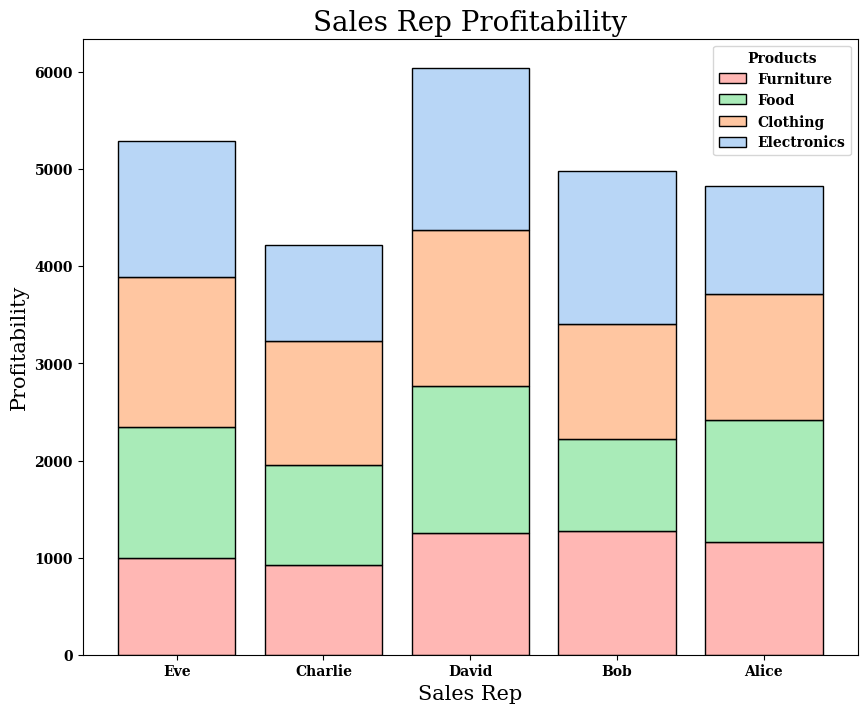

In [88]:
# Stacked barplot outlining the products sold by sales rep.
color_map = ('Furniture', 'Food', 'Clothing', 'Electronics')
sns.histplot(data=sales_t, x='Sales_Rep',weights='Quantity_Sold', 
             hue='Product_Category', multiple='stack',shrink=0.8, palette='pastel')
plt.title('Sales Rep Profitability')
plt.xlabel('Sales Rep')
plt.ylabel('Profitability')
plt.legend(color_map, title='Products')
plt.show()

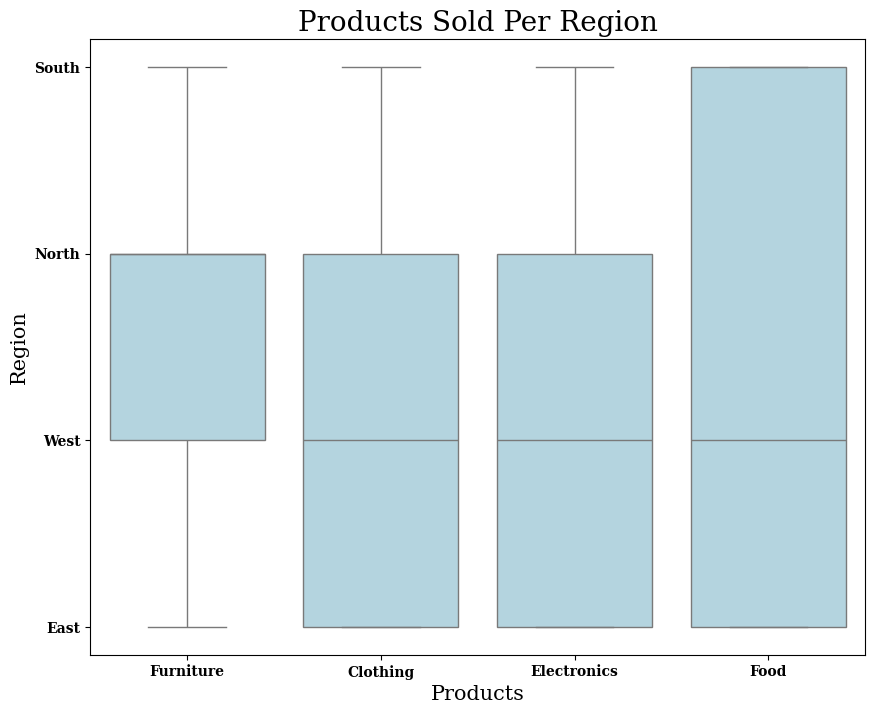

In [24]:
# box plot to compare products sold per region.
sns.boxplot(data=sales_t, x='Product_Category', y= 'Region', color='lightblue')
plt.title('Products Sold Per Region')
plt.xlabel('Products')
plt.ylabel('Region')
plt.show()

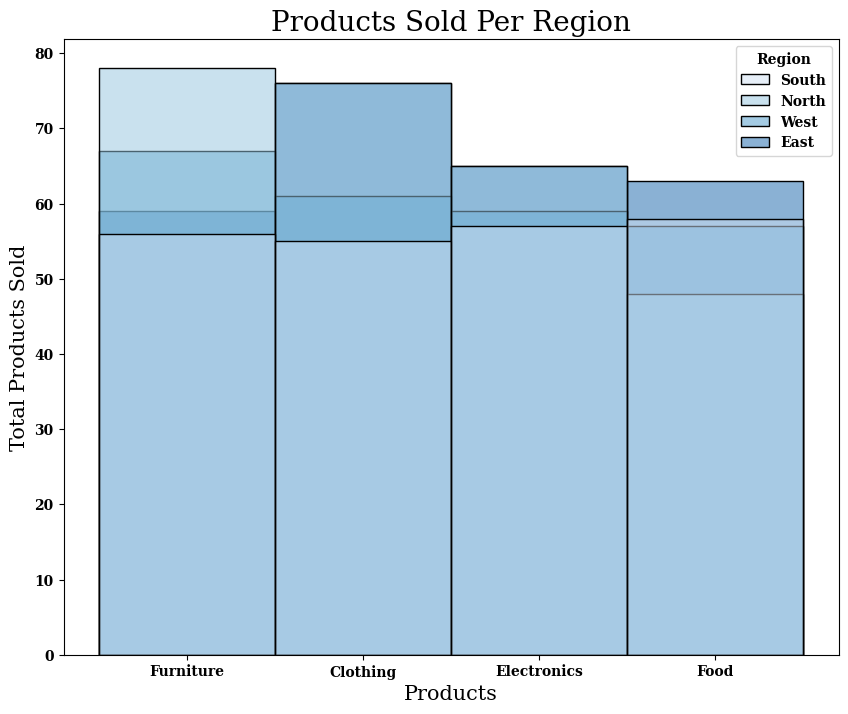

In [81]:
# Histogram to display products sold per reigon.

sns.histplot(sales_t, x = 'Product_Category', hue= 'Region', palette='Blues')
plt.title('Products Sold Per Region')
plt.xlabel('Products')
plt.ylabel('Total Products Sold')
plt.show()

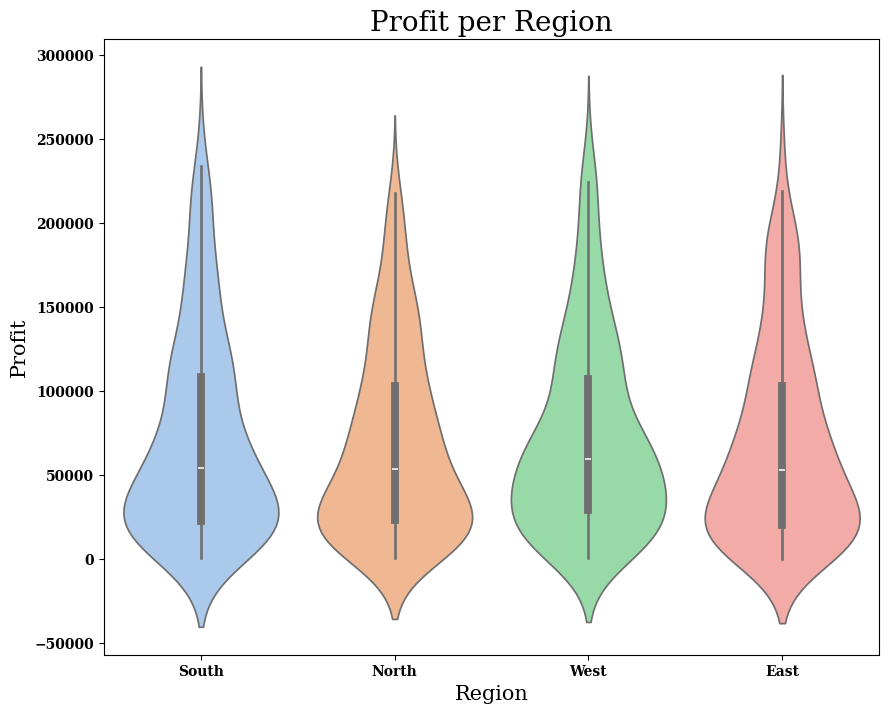

In [25]:
# Violin plot that shows the profit per sales region 
sns.violinplot(data=sales_t, x='Region', y='Profit', palette='pastel')
plt.title('Profit per Region')
plt.xlabel('Region')
plt.ylabel('Profit')

plt.show()


<h1><center>Liear Regresssion Analysis</center></h1>

In [27]:
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.metrics import mean_absolute_error, root_mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import ParameterGrid
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import accuracy_score, classification_report

In [28]:
# Resets the index for the data set.
salesOne_hot_encoding = salesOne_hot_encoding.reset_index()
salesOne_hot_encoding.head()

,Sale_Date,Product_ID,Quantity_Sold,Unit_Cost,Unit_Price,Discount,Net_Price,Profit,Total_Cost,Sales_Rep_Alice,...,Product_Category_Electronics,Product_Category_Food,Product_Category_Furniture,Customer_Type_New,Customer_Type_Returning,Payment_Method_Bank Transfer,Payment_Method_Cash,Payment_Method_Credit Card,Sales_Channel_Online,Sales_Channel_Retail
0,2023-01-01,1070,12,664.33,863.03,0.25,862.78,10353.36,7971.96,0,...,0,0,1,0,1,1,0,0,0,1
1,2023-01-01,1089,35,4071.01,4304.70,0.14,4304.56,150659.60,142485.35,0,...,0,0,0,1,0,0,0,1,1,0
2,2023-01-01,1008,38,4635.23,5075.44,0.05,5075.39,192864.82,176138.74,0,...,0,0,0,0,1,0,1,0,1,0
3,2023-01-02,1064,10,2242.01,2282.23,0.20,2282.03,22820.30,22420.10,0,...,1,0,0,0,1,0,0,1,1,0
4,2023-01-02,1075,26,4535.38,4557.56,0.00,4557.56,118496.56,117919.88,0,...,1,0,0,1,0,0,0,1,1,0


In [29]:
# Drops the sales date column.
salesOne_hot_encoding.drop(columns='Sale_Date', inplace=True)

In [30]:
# Split the data between the X and y variables.
X = salesOne_hot_encoding.drop(columns='Profit')
y = salesOne_hot_encoding['Profit']

In [31]:
# Displays the vaiables for the X data set.
X.head()

,Product_ID,Quantity_Sold,Unit_Cost,Unit_Price,Discount,Net_Price,Total_Cost,Sales_Rep_Alice,Sales_Rep_Bob,Sales_Rep_Charlie,...,Product_Category_Electronics,Product_Category_Food,Product_Category_Furniture,Customer_Type_New,Customer_Type_Returning,Payment_Method_Bank Transfer,Payment_Method_Cash,Payment_Method_Credit Card,Sales_Channel_Online,Sales_Channel_Retail
0,1070,12,664.33,863.03,0.25,862.78,7971.96,0,0,0,...,0,0,1,0,1,1,0,0,0,1
1,1089,35,4071.01,4304.70,0.14,4304.56,142485.35,0,0,1,...,0,0,0,1,0,0,0,1,1,0
2,1008,38,4635.23,5075.44,0.05,5075.39,176138.74,0,0,0,...,0,0,0,0,1,0,1,0,1,0
3,1064,10,2242.01,2282.23,0.20,2282.03,22420.10,0,0,0,...,1,0,0,0,1,0,0,1,1,0
4,1075,26,4535.38,4557.56,0.00,4557.56,117919.88,0,0,0,...,1,0,0,1,0,0,0,1,1,0


In [32]:
# Displays the data for the y variable.
y.head()

0     10353.36
1    150659.60
2    192864.82
3     22820.30
4    118496.56
Name: Profit, dtype: float64

In [33]:
# Split data between training and testing sets.
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [34]:
# Validates the data was split appropriately between training and testing sets.
print(f"The shape of X_train is: {X_train.shape}")
print(f"The shape of X_test is: {X_test.shape}")
print(f"The shape of y_train is: {y_train.shape}")
print(f"The shape of y_test is: {y_test.shape}")

The shape of X_train is: (800, 27)
The shape of X_test is: (200, 27)
The shape of y_train is: (800,)
The shape of y_test is: (200,)


In [35]:
# Creates the object for the linear regression.
model = LinearRegression()

In [36]:
# Uses the training data to build the linear regression.
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [37]:
# Predicts the target variables for the linear regression
y_pred = model.predict(X_test )

In [38]:
# This code calculates the accuracy measures for linear regression.
rsme = root_mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r_sq = r2_score(y_test, y_pred)

In [39]:
# This code prints my accuracy measures
print(f"The root squared mean error is:\n{rsme: 0.2f}\n")
print(f"The mean  squared error is:\n{mse: 0.2f}\n")
print(f"The mean absolute error is: \n{mae: 0.2f}\n")
print(f"The r2 score is:\n {r_sq: 0.2f}\n")

The root squared mean error is:
 1891.61

The mean  squared error is:
 3578202.41

The mean absolute error is: 
 1403.41

The r2 score is:
  1.00



In [40]:
# This code cross validates my linear regression.
model_kfolds = LinearRegression()
n_splits = 5
kf = KFold(n_splits= n_splits, shuffle=True, random_state=2)
scores = cross_val_score(model_kfolds, X_train, y_train, cv=kf, scoring='r2')

print(f"The R-Squared score for each fold is:\n {scores}\n")
print(f"The Mean R-Squared score is: \n{np.mean(scores)}\n")
print(f"The Standard Deviation of the R-Sqared scores are: \n{np.std(scores)}\n")

The R-Squared score for each fold is:
 [0.99855249 0.99867455 0.9990205  0.99869927 0.99893446]

The Mean R-Squared score is: 
0.9987762545736537

The Standard Deviation of the R-Sqared scores are: 
0.00017379596566544938



<h1><center>Random Forest</center></h1>

In [41]:
# Create my X and y variables for the random forest analysis
X = salesOne_hot_encoding.drop(columns=('Profit'))
y = salesOne_hot_encoding['Profit']

In [42]:
# Display the shape of my data
print(f" The shape of X data is:\n", X.shape)
print(f" \nThe shape of y data is:\n", y.shape)

 The shape of X data is:
 (1000, 27)
 
The shape of y data is:
 (1000,)


In [43]:
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y, test_size = 0.2, random_state =31)

In [44]:
print(f"The shape of my X_trai_r data is:\n", X_train_r.shape)
print(f"\nThe shape of my X_test_r data is:\n", X_test_r.shape)
print(f"\nThe shape of my y_train_r data is:\n", y_train_r.shape)
print(f"\nThe shape of my y_test_r data is:\n", y_test_r.shape)

The shape of my X_trai_r data is:
 (800, 27)

The shape of my X_test_r data is:
 (200, 27)

The shape of my y_train_r data is:
 (800,)

The shape of my y_test_r data is:
 (200,)


In [45]:
randModel = RandomForestRegressor(n_estimators=100, random_state=31)

In [46]:
randModel.fit(X_train_r,y_train_r)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [47]:
y_pred_r= randModel.predict(X_test_r)

In [48]:
mae_r = mean_absolute_error(y_test_r, y_pred_r)
mse_r = mean_squared_error(y_test_r, y_pred_r)
rmse_r = root_mean_squared_error(y_test_r, y_pred_r)
r2_r = r2_score(y_test_r, y_pred_r)

In [49]:
print(f" The Mean Absloute Error(MAE) is: \n{mae_r: .2f}")
print(f" \nThe Mean Squared Error(MSE) is: \n{mse_r: .2f}")
print(f" \nThe Root Mean Squared Error(MAE) is: \n{rmse_r: .2f}")
print(f" \nThe R2 Score is: \n{r2_r: .2f}")

 The Mean Absloute Error(MAE) is: 
 3153.57
 
The Mean Squared Error(MSE) is: 
 18784684.53
 
The Root Mean Squared Error(MAE) is: 
 4334.13
 
The R2 Score is: 
 0.99


<h1><center>Time Series Analysis</center></h1>

In [50]:
from datetime import datetime
from statsmodels.tsa.stattools import adfuller

from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing

In [51]:
# Reindex sales data to reset
sales = sales.reset_index()
sales.head()

,Sale_Date,Product_ID,Sales_Rep,Region,Sales_Amount,Quantity_Sold,Product_Category,Unit_Cost,Unit_Price,Customer_Type,Discount,Payment_Method,Sales_Channel,Net_Price,Profit,Total_Cost
0,2023-02-03,1052,Bob,North,5053.97,18,Furniture,152.75,267.22,Returning,0.09,Cash,Online,267.13,4808.34,2749.50
1,2023-04-21,1093,Bob,West,4384.02,17,Furniture,3816.39,4209.44,Returning,0.11,Cash,Retail,4209.33,71558.61,64878.63
2,2023-09-21,1015,David,South,4631.23,30,Food,261.56,371.40,Returning,0.20,Bank Transfer,Retail,371.20,11136.00,7846.80
3,2023-08-24,1072,Bob,South,2167.94,39,Clothing,4330.03,4467.75,New,0.02,Credit Card,Retail,4467.73,174241.47,168871.17
4,2023-03-24,1061,Charlie,East,3750.20,13,Electronics,637.37,692.71,New,0.08,Credit Card,Online,692.63,9004.19,8285.81


In [52]:
sales['Sale_Date'] = pd.to_datetime(sales['Sale_Date'],format ='%Y-%m-%d')

In [53]:
salesTS = sales.groupby(pd.Grouper(key='Sale_Date', freq='D'))['Profit'].mean()
salesTS = salesTS.backfill()

In [54]:
salesTS.head()

Sale_Date
2023-01-01    117959.260000
2023-01-02     70658.430000
2023-01-03     85982.196667
2023-01-04     46595.333333
2023-01-05     28773.340000
Freq: D, Name: Profit, dtype: float64

In [55]:
salesTS.tail()

Sale_Date
2023-12-28     51977.870000
2023-12-29     69693.732500
2023-12-30     44422.620000
2023-12-31    126844.156000
2024-01-01     20089.423333
Freq: D, Name: Profit, dtype: float64

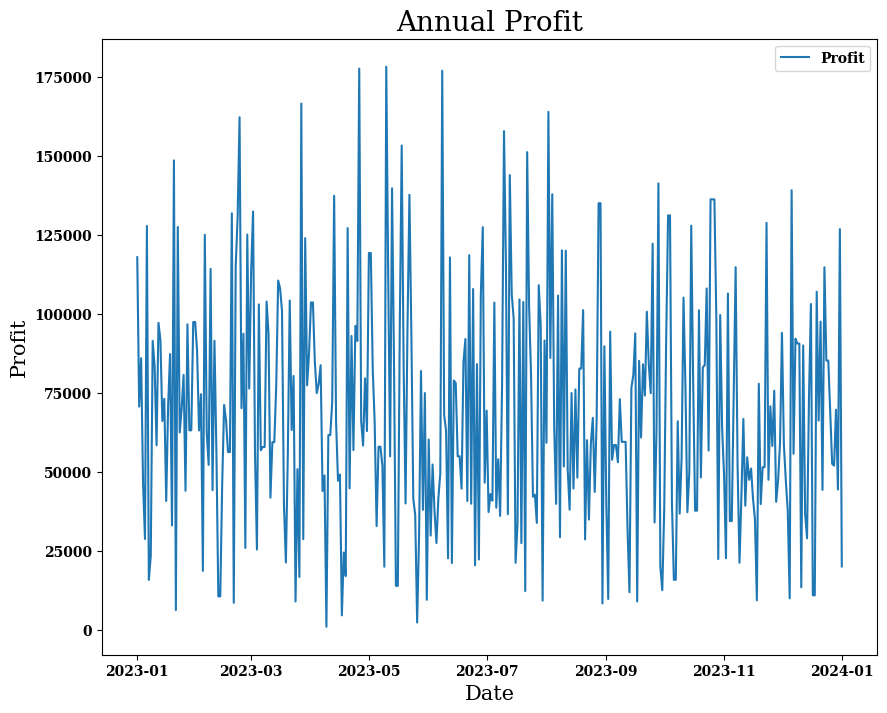

In [56]:
plt.plot(salesTS,label='Profit')
plt.title('Annual Profit')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.legend()
plt.show()

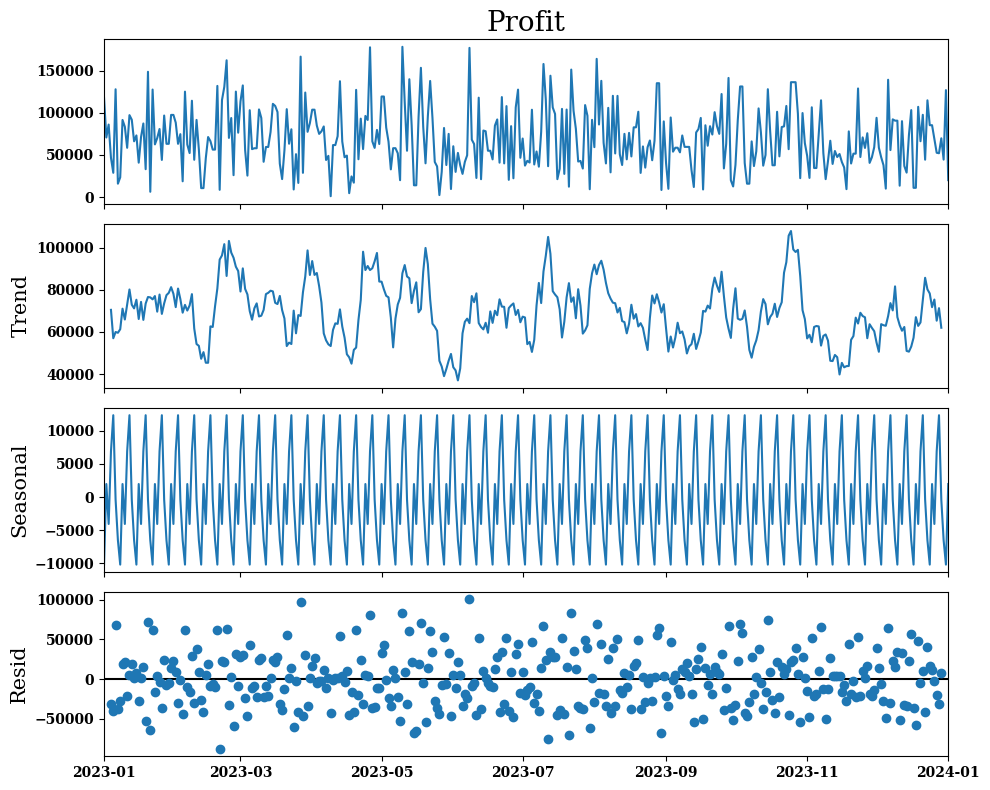

In [57]:
decomposition = seasonal_decompose(salesTS, model='additive')
fig=decomposition.plot()
plt.show()

In [58]:
# Function to determine stationarity using adfuller
def check_stationarity(timeseries):
    result = adfuller(timeseries)
    print("Augumented Adfuller test results:")
    print("ADF Statistic:", result[0])
    print("P-Value:", result[1])
    print('Critical Values:')

    for key, value in result[4].items():
        print(f"\t {key}: {value}")
    return result[1]< 0.5

is_stationary = check_stationarity(salesTS)
print(f"\nTime series is {'stationary' if is_stationary else non-stationary}")


Augumented Adfuller test results:
ADF Statistic: -11.731437055008556
P-Value: 1.3387421481089569e-21
Critical Values:
	 1%: -3.448493650810824
	 5%: -2.8695352280356556
	 10%: -2.5710293341377715

Time series is stationary


In [59]:
auto_model = auto_arima(salesTS,
                        start_p=0, start_q=0,
                        max_p=5, max_q=5,
                        m=12,
                        seasonal=True,
                        d=None,
                        trace=True,
                        error_action='ignore',
                        suppress_warnings=True,
                        stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=8747.117, Time=0.00 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=8750.728, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=8750.726, Time=0.03 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=9294.013, Time=0.00 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=8749.093, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=8749.002, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=8748.798, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=8748.842, Time=0.01 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=8750.723, Time=0.02 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 0.447 seconds


In [60]:
model = ARIMA(salesTS,
              order = auto_model.order,
              seasonal_order = auto_model.seasonal_order)
result=model.fit()

In [61]:
forecast_period = 12
forecast = result.get_forecast(steps=forecast_period)
mean_forecast = forecast.predicted_mean

In [62]:
conf_int_95 = forecast.conf_int(alpha=0.05)
conf_int_80 = forecast.conf_int(alpha=0.20)
conf_int_70 = forecast.conf_int(alpha=0.30) 

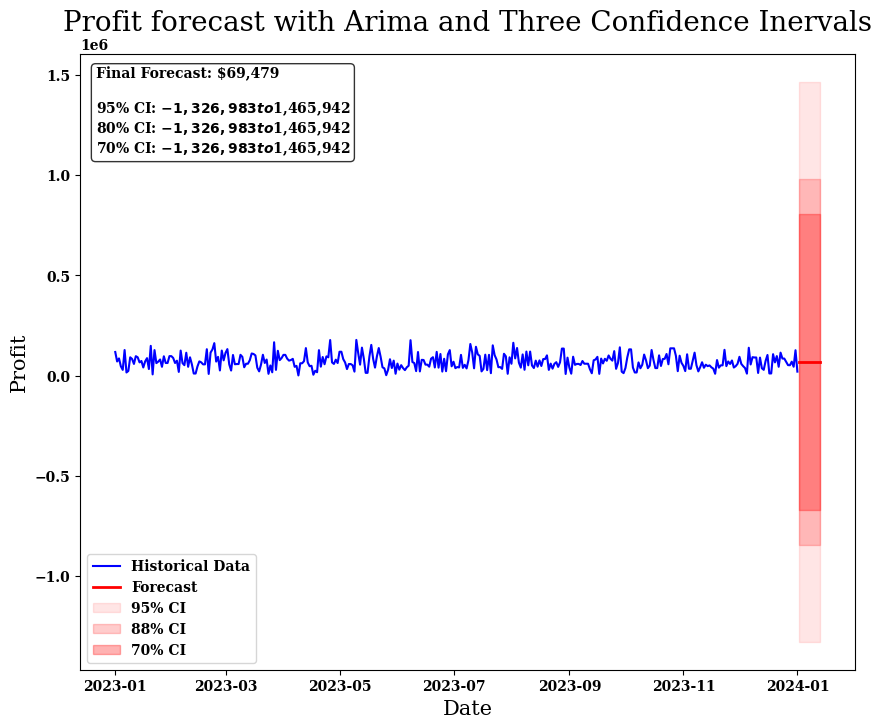

In [63]:
# Plot historical data and forecast

plt.plot(salesTS, color='blue', label='Historical Data')
plt.plot(mean_forecast, label = 'Forecast', color = 'red', linewidth = 2)

# Plot confidence intervals
plt.fill_between(mean_forecast.index,
                 conf_int_95.iloc[:, 0],
                 conf_int_95.iloc[:, 1],
                 color = 'red', alpha=0.1,
                 label = '95% CI')

plt.fill_between(mean_forecast.index,
                 conf_int_80.iloc[:, 0],
                 conf_int_80.iloc[:, 1],
                 color = 'red', alpha=0.2,
                 label = '88% CI')

plt.fill_between(mean_forecast.index,
                 conf_int_70.iloc[:, 0],
                 conf_int_70.iloc[:, 1],
                 color = 'red', alpha=0.3,
                 label = '70% CI')

plt.title('Profit forecast with Arima and Three Confidence Inervals')
plt.xlabel('Date')
plt.ylabel('Profit')
plt.legend()
#plt.grid(True, alpha = 0.3)

# Get final values

last_forecast = mean_forecast.iloc[-1]
ranges_95_lower = conf_int_95.iloc[-1,0]
ranges_95_upper = conf_int_95.iloc[-1,1]
ranges_80_lower = conf_int_95.iloc[-1,0]
ranges_80_upper = conf_int_95.iloc[-1,1]
ranges_70_lower = conf_int_95.iloc[-1,0]
ranges_70_upper = conf_int_95.iloc[-1,1]

# Create into text

info_text = f'Final Forecast: ${last_forecast:,.0f}\n\n' \
            f'95% CI: ${ranges_95_lower:,.0f} to ${ranges_95_upper:,.0f}\n' \
            f'80% CI: ${ranges_80_lower:,.0f} to ${ranges_80_upper:,.0f}\n' \
            f'70% CI: ${ranges_70_lower:,.0f} to ${ranges_70_upper:,.0f}' 

plt.text(0.02, 0.98, info_text,
         transform=plt.gca().transAxes,
         verticalalignment= 'top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))


plt.show()

In [64]:
# Calculate and display metrics
mse= mean_squared_error(salesTS, result.fittedvalues)
rmse = np.sqrt(mse)
mae = mean_absolute_error(salesTS, result.fittedvalues)

print(f"Mean Squared Error(MSE) is: {mse:.2f}")
print(f"Root Mean Squared Error (RMSE) is: {rmse:.2f}")
print(f"Mean Absoulute Error (MAE)is: {mae:.2f}")

# Print forecast information.
print(f"\nForecast Ranges for Final Period:")
print(f"Point Forecast: ${last_forecast:,.2f}")
print(f"\nConfidence Intervals (CI):")
print(f"95% CI: ${ranges_95_lower:,.2f} to ${ranges_95_upper:,.2f}")
print(f"80% CI: ${ranges_80_lower:,.2f} to ${ranges_80_upper:,.2f}")
print(f"70% CI: ${ranges_70_lower:,.2f} to ${ranges_70_upper:,.2f}")

# Calculate and print interval widths.
print(f"\nInterval Widths as a Percentage of Forecast")
print(f"95% CI: \u00B1{((ranges_95_upper - ranges_95_lower)/2/last_forecast*100):,.1f}%")
print(f"80% CI: \u00B1{((ranges_80_upper - ranges_80_lower)/2/last_forecast*100):,.1f}%")
print(f"70% CI: \u00B1{((ranges_70_upper - ranges_70_lower)/2/last_forecast*100):,.1f}%")

# Create forecast dataframe
forecast_df = pd.DataFrame({
    'Forecast': mean_forecast,
    '95% Lower': conf_int_95.iloc[:,0],
    '95% Upper': conf_int_95.iloc[:,1],
    '80% Lower': conf_int_80.iloc[:,0],
    '80% Upper': conf_int_80.iloc[:,1],
    '70% Lower': conf_int_70.iloc[:,0],
    '70% Upper': conf_int_70.iloc[:,1]
})

print("\nDetailed Forecast with Confidence Intervals:")
print(forecast_df)



Mean Squared Error(MSE) is: 1387015466.13
Root Mean Squared Error (RMSE) is: 37242.66
Mean Absoulute Error (MAE)is: 30439.92

Forecast Ranges for Final Period:
Point Forecast: $69,479.42

Confidence Intervals (CI):
95% CI: $-1,326,983.11 to $1,465,941.94
80% CI: $-1,326,983.11 to $1,465,941.94
70% CI: $-1,326,983.11 to $1,465,941.94

Interval Widths as a Percentage of Forecast
95% CI: ±2,009.9%
80% CI: ±2,009.9%
70% CI: ±2,009.9%

Detailed Forecast with Confidence Intervals:
                Forecast     95% Lower     95% Upper      80% Lower  \
2024-01-02  69479.419692 -1.326983e+06  1.465942e+06 -843618.345984   
2024-01-03  69479.419692 -1.326983e+06  1.465942e+06 -843618.345984   
2024-01-04  69479.419692 -1.326983e+06  1.465942e+06 -843618.345984   
2024-01-05  69479.419692 -1.326983e+06  1.465942e+06 -843618.345984   
2024-01-06  69479.419692 -1.326983e+06  1.465942e+06 -843618.345984   
2024-01-07  69479.419692 -1.326983e+06  1.465942e+06 -843618.345984   
2024-01-08  69479.41969

In [65]:
models = []

specifications = [
    {
        'name': 'Fixed Parameters',
        'model': ExponentialSmoothing(
            salesTS,
            seasonal_periods = 12,
            trend = 'add',
            seasonal = 'add',
            damped_trend = True
       ).fit(
           smoothing_level = 0.2,
           smoothing_trend = 0.1,
           smoothing_seasonal = 0.1,
           damping_trend = 0.98,
           optimized = False
       )

    },
    {
        'name': 'Multiplicative Seasonal',
        'model': ExponentialSmoothing(
            salesTS,
            seasonal_periods = 12,
            trend = 'add',
            seasonal = 'mul',
            damped_trend = True
       ).fit(
           smoothing_level = 0.2,
           smoothing_trend = 0.1,
           smoothing_seasonal = 0.1,
           damping_trend = 0.98,
           optimized = False
       )
    },
    {
       'name': 'Multiplicative Trend',
        'model': ExponentialSmoothing(
            salesTS,
            seasonal_periods = 12,
            trend = 'mul',
            seasonal = 'add',
            damped_trend = True
       ).fit(
           smoothing_level = 0.2,
           smoothing_trend = 0.1,
           smoothing_seasonal = 0.1,
           damping_trend = 0.98,
           optimized = False
       ) 
    }
]

In [66]:
results =[]
for spec in specifications:
    model = spec['model']
    name = spec['name']

# Calcualte metrics
rmse = np.sqrt(mean_squared_error(salesTS, model.fittedvalues))
mae = mean_absolute_error(salesTS, model.fittedvalues)

results.append({
    'name': name,
    'rmse': rmse,
    'mae': mae,
    'model': model
})



In [67]:
best_model = min(results, key=lambda x: x['rmse'])
hw_model = best_model['model']
hw_forecast = hw_model.forecast(12)

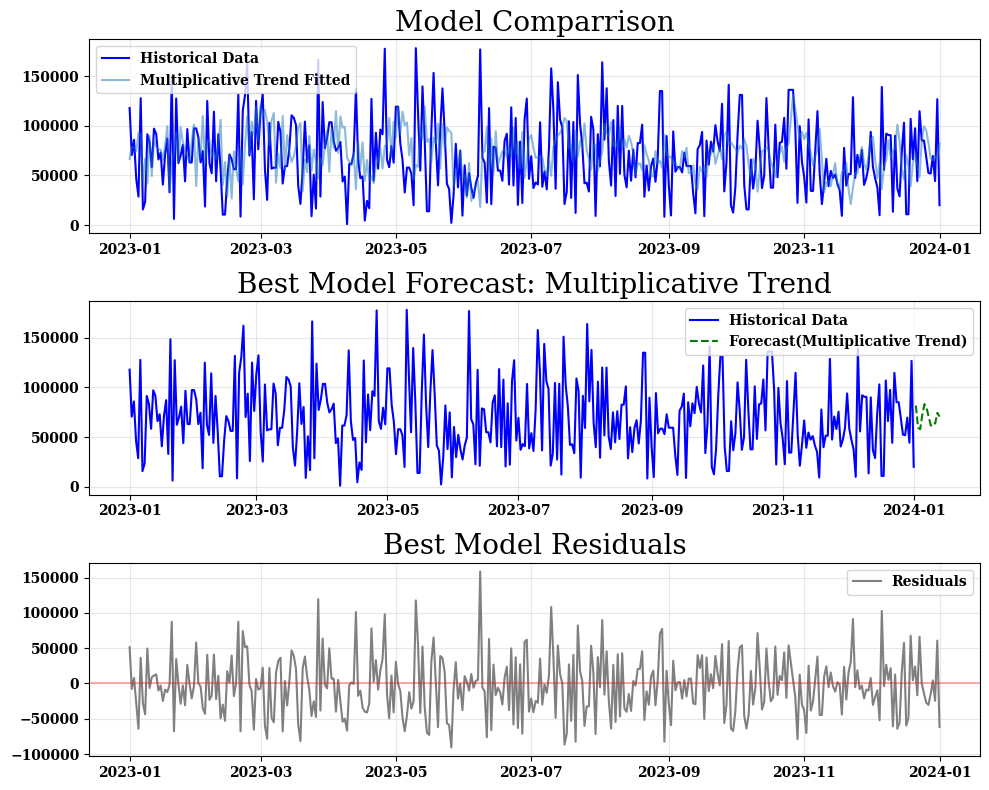

In [68]:
# First subplot: All models
plt.subplot(3, 1, 1)
plt.plot(salesTS.index, salesTS, label = 'Historical Data', color = 'blue')
for result in results:
    plt.plot(result['model'].fittedvalues.index,
             result['model'].fittedvalues,
             label = f"{result['name']} Fitted",
             alpha = 0.5)
plt.title('Model Comparrison')
plt.legend()
plt.grid(True, alpha=0.3)

# Second subplot
plt.subplot(3, 1, 2)
plt.plot(salesTS.index, salesTS, label = 'Historical Data', color = 'blue')
plt.plot(hw_forecast.index, hw_forecast,
         label = f'Forecast({best_model['name']})',
          color = 'green', linestyle= '--' )
plt.title(f'Best Model Forecast: {best_model["name"]}')
plt.legend()
plt.grid(True, alpha = 0.3)

# Third subplot, residuals of best model
plt.subplot(3, 1, 3)
residuals= salesTS - hw_model.fittedvalues
plt.plot(salesTS.index, residuals, label = 'Residuals', color = 'gray')
plt.axhline(y = 0, color = 'r', linestyle = '-', alpha = 0.3)
plt.title('Best Model Residuals')
plt.legend()
plt.grid(True, alpha = 0.3)

plt.tight_layout()
plt.show()

In [69]:
print("\nModel Comparison:")
for result in results:
    print(f"\n{result['name']}:")
    print(f"\nRMSE:${result['rmse']: .2f}")
    print(f"\nMAE: ${result['mae']: .2f}")

print(f"\nBest Model: {best_model['name']}")
print(f"Best RMSE: ${best_model['rmse']: .2f}")


Model Comparison:

Multiplicative Trend:

RMSE:$ 41741.03

MAE: $ 33003.13

Best Model: Multiplicative Trend
Best RMSE: $ 41741.03


In [70]:
print("\nBest Model Parameters:")
print(f"- Smoothing level (\u03B1): {hw_model.params['smoothing_level']: .3f}")
print(f"- Trend smoothing ('\u03B2'): {hw_model.params['smoothing_trend']: .3f}")
print(f"- Seasonal smoothing ('\u03B3'): {hw_model.params['smoothing_seasonal']: .3f}")
print(f"- Damping parameter ('\u03C6'): {hw_model.params['damping_trend']: .3f}")


Best Model Parameters:
- Smoothing level (α):  0.200
- Trend smoothing ('β'):  0.100
- Seasonal smoothing ('γ'):  0.100
- Damping parameter ('φ'):  0.980


In [71]:
hw_forecast

2024-01-02    81865.345571
2024-01-03    59613.978860
2024-01-04    57972.972971
2024-01-05    72589.526887
2024-01-06    83209.369705
2024-01-07    79003.626790
2024-01-08    70186.444888
2024-01-09    61513.320980
2024-01-10    64358.354560
2024-01-11    63780.060389
2024-01-12    74451.320733
2024-01-13    70661.597201
Freq: D, dtype: float64

In [72]:
final_results = pd.DataFrame({
    'Actual': salesTS,
    'Fitted': hw_model.fittedvalues,
    'residuals': residuals

})

In [73]:
final_results

,Actual,Fitted,residuals
Sale_Date,,,
2023-01-01,117959.260000,66675.931156,51283.328844
2023-01-02,70658.430000,78367.578698,-7709.148698
2023-01-03,85982.196667,78134.024924,7848.171743
2023-01-04,46595.333333,74541.229275,-27945.895942
2023-01-05,28773.340000,92952.934140,-64179.594140
...,...,...,...
2023-12-28,51977.870000,67365.193383,-15387.323383
2023-12-29,69693.732500,65476.658151,4217.074349
2023-12-30,44422.620000,69010.980474,-24588.360474
